In [1]:
from init_nb import init_notebook
config = init_notebook()

from pathlib import Path
from functools import reduce
import matplotlib.pyplot as plt
import pandas as pd
import joblib
import numpy as np
import seaborn as sns
from nilearn import plotting
import nibabel as nib
import itertools
from bold_dementia.connectivity import Atlas, group_by_networks, plot_matrix, reshape_pvalues, block_block
from bold_dementia.utils.iterables import unique

ATLAS = "gillig"
SOFT = False
ALPHA = config["alpha"]

In [2]:
atlas = Atlas.from_name(ATLAS, soft=SOFT)
atlas.labels_.pop(0)
coords = atlas.get_coords()
n_regions = len(atlas.labels)
labels = tuple(sorted(unique(atlas.macro_labels)))

In [3]:

expnames = (f"atlas-{ATLAS}_test_no-gsr_ols-cenanom", f"atlas-{ATLAS}_retest_no-gsr_ols-cenanom")
tmaps = []


for expname in expnames:
    matrices_path = Path(
        f"{config['output_dir']}/statresults/{expname}"
    )
    print(f"Loading matrices from {matrices_path}")
    try:
        fdrmat = joblib.load(matrices_path / "pmat.joblib")
        tstats = joblib.load(matrices_path / "statmap.joblib")
    except FileNotFoundError:
        print("Fetching results from resdf")

    thresholded_t = tstats * np.where(fdrmat < ALPHA, 1, 0)
    tmaps.append(tstats)

Loading matrices from /homes_unix/jlegrand/data/Memento/output/statresults/atlas-gillig_test_no-gsr_ols-cenanom
Loading matrices from /homes_unix/jlegrand/data/Memento/output/statresults/atlas-gillig_retest_no-gsr_ols-cenanom


In [4]:
idx = np.tril_indices(n_regions, k=-1)
tvecs = [t[idx] for t in tmaps]
maximums = (np.max(np.abs(t)) for t in tvecs)
maxt = reduce(max, maximums)


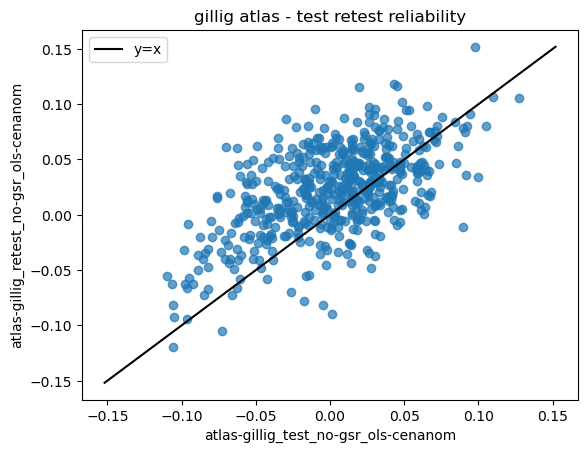

In [5]:
plt.scatter(tvecs[0], tvecs[1], alpha=0.7)
plt.plot([-maxt, maxt], [-maxt, maxt], color="black", label="y=x")
plt.xlabel(f"{expnames[0]}")
plt.ylabel(f"{expnames[1]}")
plt.title(f"{atlas.name} atlas - test retest reliability")
plt.legend()
plt.show()

In [14]:
conn_names = (f"atlas-{atlas.name}_test_no-gsr", f"atlas-{atlas.name}_retest_no-gsr")

cmaps = []

from bold_dementia import get_config
for conn_name in conn_names:
    connectivity_path = Path(
        f"{config['output_dir']}/connectivity/{conn_name}"
    )
    params = get_config(connectivity_path / "parameters.yml")
    pos = params["posfunc"]
    neg = params["negfunc"]
    print(f"Loading matrices from {connectivity_path}")
    AD = joblib.load(connectivity_path / f"{pos}.joblib")
    control = joblib.load(connectivity_path / f"{neg}.joblib")

    cmaps.append(
        np.vstack((AD, control))
    )

Loading matrices from /homes_unix/jlegrand/data/Memento/output/connectivity/atlas-gillig_test_no-gsr
Loading matrices from /homes_unix/jlegrand/data/Memento/output/connectivity/atlas-gillig_retest_no-gsr


In [15]:
cvecs = [cmap.mean(axis=0)[idx] for cmap in cmaps]

In [16]:
trt = np.vstack(tvecs)
conn = np.mean(cvecs, axis=0)

df = pd.DataFrame(np.vstack((trt, conn)).T, columns=["test", "retest", "connectivity"])

<Axes: xlabel='test', ylabel='retest'>

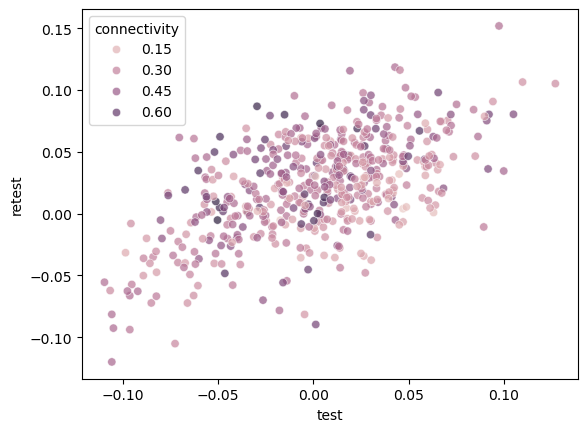

In [17]:
sns.scatterplot(df, x="test", y="retest", hue="connectivity", alpha=0.7)

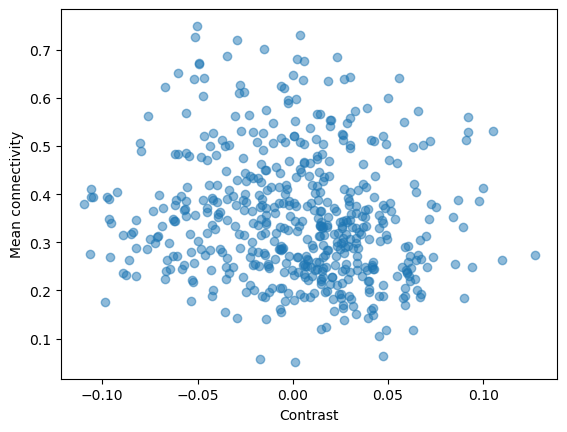

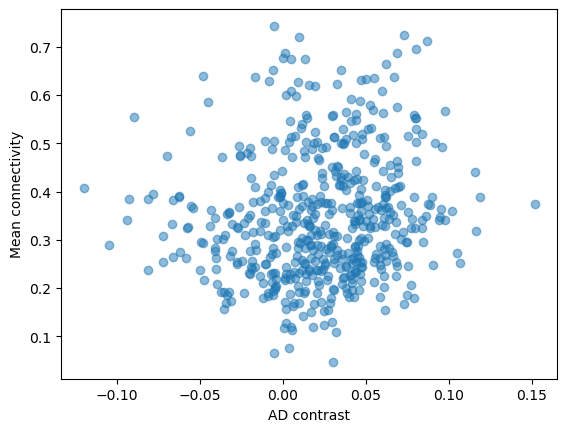

In [19]:
plt.scatter(tvecs[0], cvecs[0], alpha=0.5)
plt.xlabel("Contrast")
plt.ylabel("Mean connectivity")
#plt.ylim(-0.75, 0.75)
plt.show()

plt.scatter(tvecs[1], cvecs[1], alpha=0.5)
plt.xlabel("AD contrast")
plt.ylabel("Mean connectivity")
#plt.ylim(-0.75, 0.75)
plt.show()